In [1]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# External libraries
import os as so
import sys as s
import pathlib as pl
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader, ConcatDataset
import torcheval
from torcheval.metrics import MulticlassF1Score, Mean
import optuna as opt
import torchvision as tn
import sklearn as sn
from sklearn.metrics import f1_score
import pandas as ps
import numpy as ny
import typing as t
import pathlib as pl
import matplotlib.pyplot as pt
import random as rng
from tqdm import tqdm
import tqdm as tm
from pprint import pprint
from git import Repo
import lightning as tl
import kornia as K

In [3]:
# Add local package to path
if (p := pl.Path(so.getcwd(), '..').absolute().as_posix()) not in s.path:
    s.path.append(p)

# Local imports
from gic import *
from gic.models.autoencoder import AutoEncoder
from gic.data import GenImageDataset, load_batched_data, GenImageAugment, MaskAugment
from gic.models.convnext import ConvBlock, PatchBlock, ActivFn

wandb: Currently logged in as: invokariman (castelvaar). Use `wandb login --relogin` to force relogin
/home/invokariman/Projects/git/ub-g21-deeplearning/projects/gic/notebooks/../gic/__init__.py:57: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wn_callback = WeightsAndBiasesCallback(
/home/invokariman/Projects/git/ub-g21-deeplearning/projects/gic/notebooks/../gic/tune.py:119: ExperimentalWarning: track_in_wandb is experimental (supported from v3.0.0). The interface can change in the future.
  @forward_self(wn_callback.track_in_wandb())


AutoEncoder Model

In [4]:
net = AutoEncoder(64, 256, 'SiLU').to(DEVICE)

In [5]:
X_rgb = torch.randn((8, 3, 64, 64), device=DEVICE)

with torch.no_grad():
    print(f'X: {X_rgb.shape}')
    print(f'U: {net(X_rgb)[0].shape}, E: {net(X_rgb)[1].shape}')

X: torch.Size([8, 3, 64, 64])
U: torch.Size([8, 3, 64, 64]), E: torch.Size([8, 512, 8, 8])


Training

In [50]:
# Load data
train_lr, _, _ = load_batched_data(DATA_PATH, 'train', batch_size=16, normalize=False, prefetch_factor=prefetch_factor, num_workers=num_workers, pin_memory=pin_memory)
train_lr_raw, _, _ = load_batched_data(DATA_PATH, 'train', batch_size=16, normalize=False, prefetch_factor=prefetch_factor, num_workers=num_workers, pin_memory=pin_memory)

# Create trainer
trainer = tl.Trainer(max_epochs=30)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [51]:
trainer.fit(model=net, train_dataloaders=train_lr)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | unet | UNet | 26.1 M
------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.208   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [52]:
torch.save(net.state_dict(), 'unet.pt')

In [6]:
net = AutoEncoder(64, 256, 'SiLU').to(DEVICE)
net.load_state_dict(torch.load('unet.pt'))
net = net.eval().requires_grad_(False)

In [7]:
# Load test data
_, _, test_lr = load_batched_data(DATA_PATH, 'disjoint', batch_size=16, normalize=False, prefetch_factor=prefetch_factor, num_workers=num_workers, pin_memory=pin_memory)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


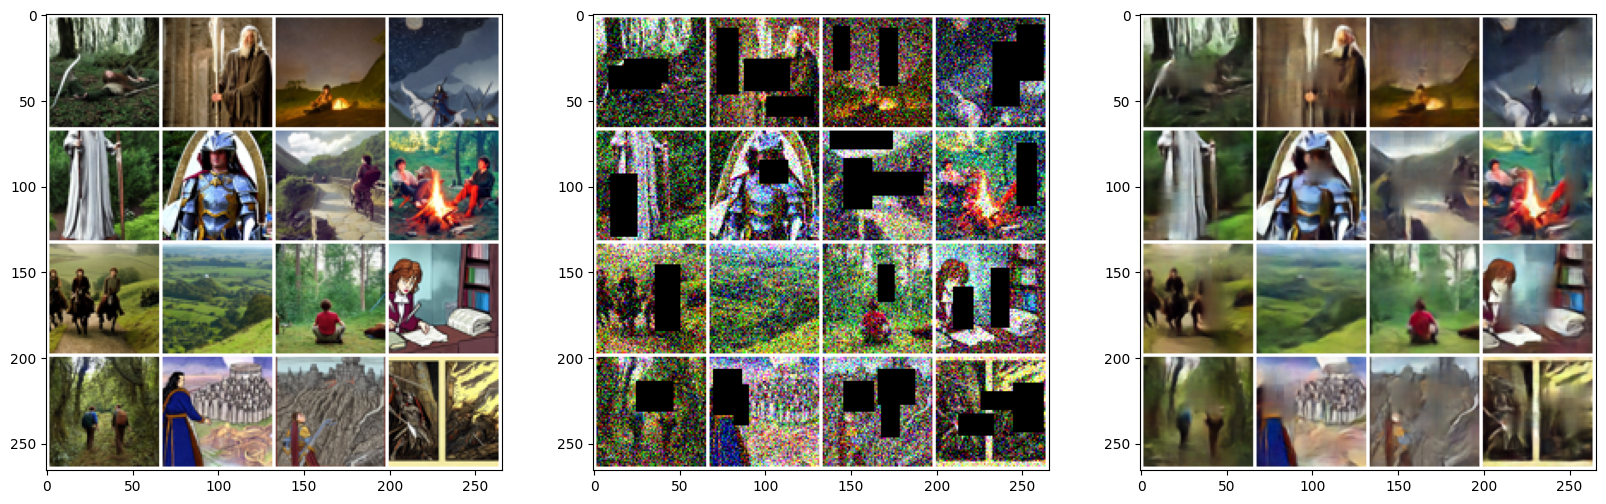

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


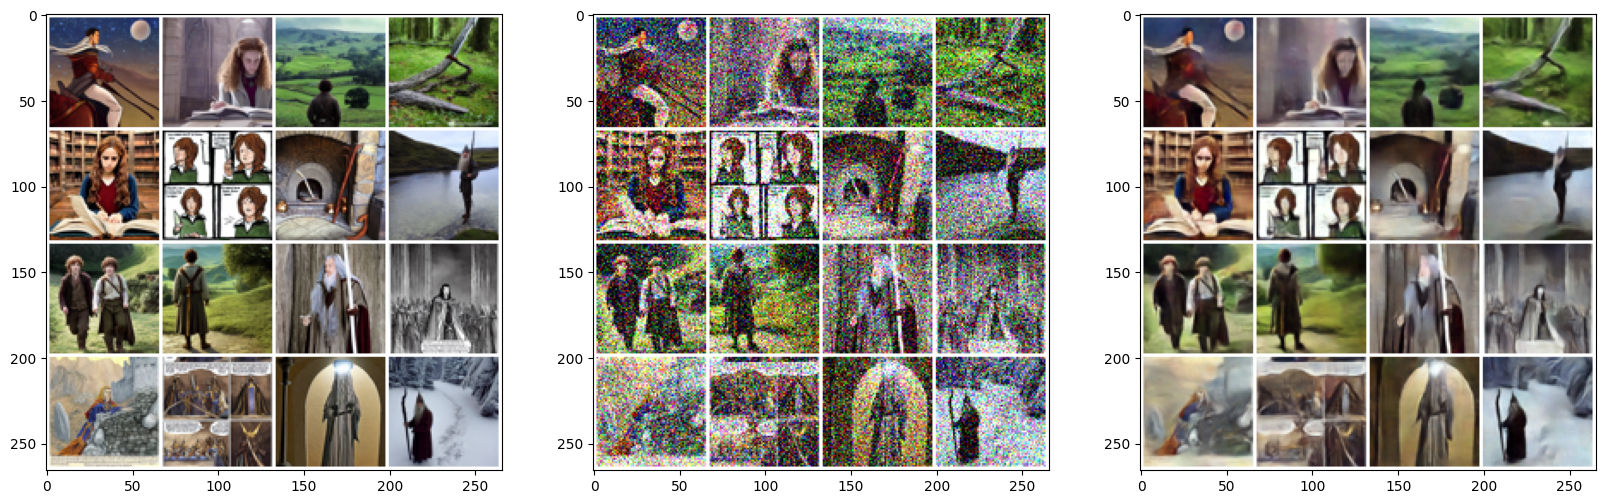

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


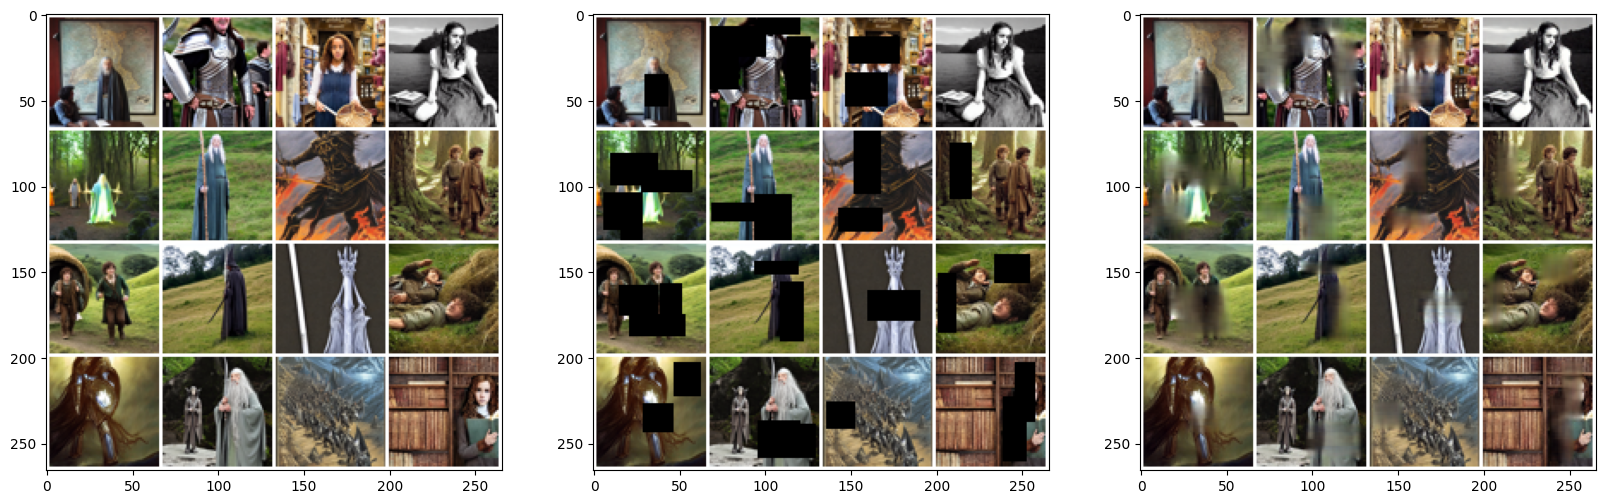

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

In [9]:
# Select operations
tr_denorm = K.enhance.Denormalize(torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225]))
tr_norm = GenImageAugment(augment=False, normalize=True)
tr_mask = MaskAugment()

# Create operations
for X_raw in test_lr:
    # Apply masking optionally
    X_mask = tr_mask(X_raw)

    # Apply AutoEncoder
    X_rev = tr_denorm(net(tr_norm(X_mask.to(DEVICE)))[0]).cpu()

    # Prepare Grid
    raw_grid = tn.utils.make_grid(X_raw, nrow=4, pad_value=5)
    mask_grid = tn.utils.make_grid(X_mask, nrow=4, pad_value=5)
    rev_grid = tn.utils.make_grid(X_rev, nrow=4, pad_value=5)

    # Display Grid
    f, ax = pt.subplots(1, 3, figsize=(20, 20))
    ax[0].imshow(raw_grid.permute((1, 2, 0)))
    ax[1].imshow(mask_grid.permute((1, 2, 0)))
    ax[2].imshow(rev_grid.permute((1, 2, 0)))
    pt.show()